# Testing Area for the eCPA

Testing is done on 12 different scenarios that are partly inspired by the conventional Imazu Problem (Imazu 1987). All scenarios are run two times: once with constant speed and again with variing velocity.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import simps

from interpolate_path import interpolate_path
from eCPA_for_demo import compute_ecpa
from standard_cpa import calculate_standard_cpa

## Functions

In [2]:
# Plot the given scenario.
def plotting(own_ship, target_ship, final_cpa, axis_measure=[0, 300, 0, 300]):
    
    # Prepare the plot
    plt.figure(figsize=(6, 6))
    plt.axis(axis_measure)
    plt.axis('square')
    plt.xlim(axis_measure[0], axis_measure[1])
    plt.ylim(axis_measure[2], axis_measure[3])
    plt.grid(True)
    plt.xticks([0, 66.15, 132.3, 198.45, 264.6], ['0', '0.5', '1', '1.5', '2'])
    plt.yticks([0, 66.15, 132.3, 198.45, 264.6], ['0', '0.5', '1', '1.5', '2'])
    plt.xlabel('Nautical Miles [NM]')
    plt.ylabel('Nautical Miles [NM]')

    # Plot the ships starting positions
    plt.plot(own_ship[0]['x'], own_ship[0]['y'], "ob", markersize=10, zorder=2)
    plt.plot(target_ship[0]['x'], target_ship[0]['y'], "og", markersize=10, zorder=2)

    # Plot the ships heading as arrow with constant length
    plt.arrow(own_ship[0]['x'], own_ship[0]['y'], 10 * math.sin(math.radians(own_ship[0]['heading'])),
                10 * math.cos(math.radians(own_ship[0]['heading'])),
                head_width=10, head_length=10, color='b', zorder=2)
    plt.arrow(target_ship[0]['x'], target_ship[0]['y'], 10 * math.sin(math.radians(target_ship[0]['heading'])),
                10 * math.cos(math.radians(target_ship[0]['heading'])),
                head_width=10, head_length=10, color='g', zorder=2)
    
    # Plot the ships final positions
    plt.plot(own_ship[-1]['x'], own_ship[-1]['y'], "xb", markersize=10, markeredgewidth=4, zorder=2)
    plt.plot(target_ship[-1]['x'], target_ship[-1]['y'], "xg", markersize=10, markeredgewidth=4, zorder=2)

    # Extract the position coordinates from the data
    x1_positions = [entry['x'] for entry in own_ship]
    y1_positions = [entry['y'] for entry in own_ship]
    x2_positions = [entry['x'] for entry in target_ship]
    y2_positions = [entry['y'] for entry in target_ship]

    # Interpolate the paths by the chosen method (linear, quadratic, cubic, cubic_spline, cubic_hermite_spline, pchip, akima)
    interpolated_x1, interpolated_y1 = interpolate_path(x1_positions, y1_positions, 'cubic_spline')
    interpolated_x2, interpolated_y2 = interpolate_path(x2_positions, y2_positions, 'cubic_spline')
    
    # Plot the interpolated course of the ships
    plt.plot(interpolated_x1, interpolated_y1, color='darkblue', linestyle='--', linewidth=2)
    plt.plot(interpolated_x2, interpolated_y2, color='darkgreen', linestyle='--', linewidth=2)

    # Plot the CPA as red 'X'
    plt.plot(final_cpa[0], final_cpa[1], "x", markersize=16.5, markeredgewidth=5, color='white')
    plt.plot(final_cpa[0], final_cpa[1], "xr", markersize=15, markeredgewidth=3)

    plt.show()

In [3]:
# TODO Delete; Parameters just for temporary testing with a simple computation

# Dynamic courses (otherwise everything is linear)?
dynamic = True
# Dynamic prediction method (double_exponential, triple_exponential, polynomial)
prediction_method = 'double_exponential'
# Dynamic interpolation method (linear, quadratic, cubic, cubic_spline, cubic_hermite_spline, pchip, akima)
interpolation_method = 'akima'
# Dynamic course forecast steps
forecast_steps = 7
# How many past_timesteps should go into the dynamic prediction?
past_timesteps = 3
# Shall an approximation of the real DCPA (given the ships dimensions) be included in the result?
r_dcpa = False
# Shall the Obstacle Zone by Target (OZT) method be activated (only possible in linear mode!)?
ozt = False
# Define the security radius for the vessels (one point is approximately 14 meters)
security_radius = 7

In [4]:
# Compute the Mean Squared Error (MSE) between the eCPA, Standard CPA and the real Closest Point of Approach (final_cpa).
def compute_mse(own_ship, target_ship, final_cpa, final_cpa_timestep, final_tcpa, final_dcpa):

    # Initialize the MSE values
    mse_ecpa = 0
    mse_cpa = 0
    mse_etcpa = 0
    mse_tcpa = 0
    mse_edcpa = 0
    mse_dcpa = 0

    # Run the computation for each timestep
    for i in range(1, final_cpa_timestep):
        # Compute the eCPA
        eCPA, time_to_CPA, distance_at_CPA, rDCPA = compute_ecpa(dynamic=dynamic,
                                                                prediction_method=prediction_method,
                                                                interpolation_method=interpolation_method,
                                                                forecast_steps=forecast_steps,
                                                                past_timesteps=past_timesteps,
                                                                r_dcpa=r_dcpa,
                                                                ozt=ozt,
                                                                ship1=own_ship[:i+1],
                                                                ship2=target_ship[:i+1],
                                                                security_radius=security_radius,
                                                                )

        # Compute the MSE for the eCPA results
        mse_ecpa += (eCPA[0] - final_cpa[0])**2 + (eCPA[1] - final_cpa[1])**2
        mse_etcpa += (time_to_CPA - final_tcpa + own_ship[i]['timestamp'])**2
        mse_edcpa += (distance_at_CPA - final_dcpa)**2

        # Compute the Standard CPA
        cpa, cpa_distance, time_to_cpa = calculate_standard_cpa(own_ship[i], target_ship[i])

        # Compute the MSE for the CPA results
        mse_cpa += (cpa[0][0] - final_cpa[0])**2 + (cpa[0][1] - final_cpa[1])**2
        mse_tcpa += (time_to_cpa - final_tcpa + own_ship[i]['timestamp'])**2
        mse_dcpa += (cpa_distance - final_dcpa)**2

    # Normalize the MSE values over all computed timesteps
    mse_ecpa /= (final_cpa_timestep - 1)
    mse_cpa /= (final_cpa_timestep - 1)
    mse_etcpa /= (final_cpa_timestep - 1)
    mse_tcpa /= (final_cpa_timestep - 1)
    mse_edcpa /= (final_cpa_timestep - 1)
    mse_dcpa /= (final_cpa_timestep - 1)

    return mse_ecpa, mse_cpa, mse_etcpa, mse_tcpa, mse_edcpa, mse_dcpa

## Scenarios

In [5]:
# Initialize the overall MSE values for the end results
overall_mse_ecpa = []
overall_mse_cpa = []
overall_mse_etcpa = []
overall_mse_tcpa = []
overall_mse_edcpa = []
overall_mse_dcpa = []

### Scenarios with Constant Speed

#### Scenario 1

MSE eCPA: 0.004267731194656342
MSE CPA: 0.0
MSE eTCPA: 1.4199496293978213e-30
MSE TCPA: 1.5777218104420237e-31
MSE eDCPA: 0.017070924778623365
MSE DCPA: 0.0


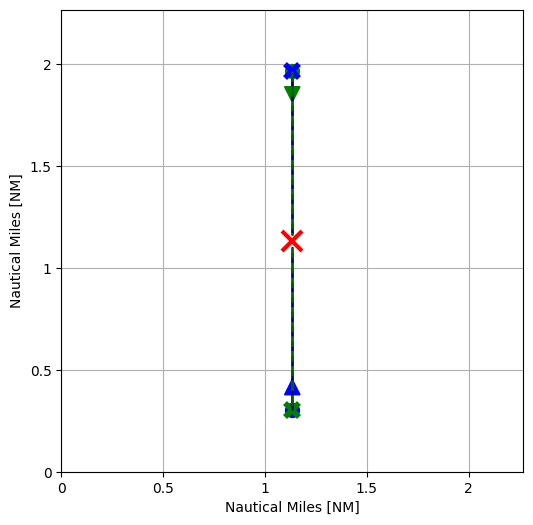

In [6]:
own_ship1 = [{'x': 150, 'y': 40, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 62, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 84, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 106, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 128, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 172, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 194, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 216, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 238, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship1 = [{'x': 150, 'y': 260, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 238, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 216, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 194, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 172, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 150, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 128, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 106, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 84, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 62, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 40, 'COG': 180, 'SOG': 10.0, 'heading': 180, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa1 = [150, 150]
final_tcpa1 = 11.0
final_dcpa1 = 0.0

mse_ecpa1, mse_cpa1, mse_etcpa1, mse_tcpa1, mse_edcpa1, mse_dcpa1 = compute_mse(own_ship1, target_ship1, final_cpa1, 6, final_tcpa1, final_dcpa1)
overall_mse_ecpa.append(mse_ecpa1)
overall_mse_cpa.append(mse_cpa1)
overall_mse_etcpa.append(mse_etcpa1)
overall_mse_tcpa.append(mse_tcpa1)
overall_mse_edcpa.append(mse_edcpa1)
overall_mse_dcpa.append(mse_dcpa1)

print("MSE eCPA:", mse_ecpa1)
print("MSE CPA:", mse_cpa1)
print("MSE eTCPA:", mse_etcpa1)
print("MSE TCPA:", mse_tcpa1)
print("MSE eDCPA:", mse_edcpa1)
print("MSE DCPA:", mse_dcpa1)

plotting(own_ship1, target_ship1, final_cpa1)

#### Scenario 2

MSE eCPA: 0.004267731194656342
MSE CPA: 3.2311742677852645e-28
MSE eTCPA: 1.4199496293978213e-30
MSE TCPA: 2.68212707775144e-30
MSE eDCPA: 0.008535462389311682
MSE DCPA: 4.846761401677897e-28


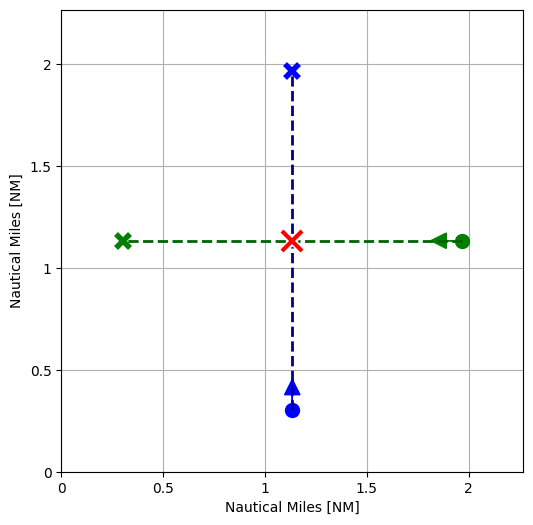

In [7]:
own_ship2 = [{'x': 150, 'y': 40, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 62, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 84, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 106, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 128, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 172, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 194, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 216, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 238, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship2 = [{'x': 260, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 238, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 216, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 194, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 172, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 128, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 106, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 84, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 62, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 40, 'y': 150, 'COG': 270, 'SOG': 10.0, 'heading': 270, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa2 = [150, 150]
final_tcpa2 = 11.0
final_dcpa2 = 0.0

mse_ecpa2, mse_cpa2, mse_etcpa2, mse_tcpa2, mse_edcpa2, mse_dcpa2 = compute_mse(own_ship2, target_ship2, final_cpa2, 6, final_tcpa2, final_dcpa2)
overall_mse_ecpa.append(mse_ecpa2)
overall_mse_cpa.append(mse_cpa2)
overall_mse_etcpa.append(mse_etcpa2)
overall_mse_tcpa.append(mse_tcpa2)
overall_mse_edcpa.append(mse_edcpa2)
overall_mse_dcpa.append(mse_dcpa2)

print("MSE eCPA:", mse_ecpa2)
print("MSE CPA:", mse_cpa2)
print("MSE eTCPA:", mse_etcpa2)
print("MSE TCPA:", mse_tcpa2)
print("MSE eDCPA:", mse_edcpa2)
print("MSE DCPA:", mse_dcpa2)

plotting(own_ship2, target_ship2, final_cpa2)

#### Scenario 3

MSE eCPA: 0.12066040013990154
MSE CPA: 3.2311742677852645e-28
MSE eTCPA: 0.001548800000000034
MSE TCPA: 5.2064819744586776e-30
MSE eDCPA: 0.00017070924778586307
MSE DCPA: 0.0


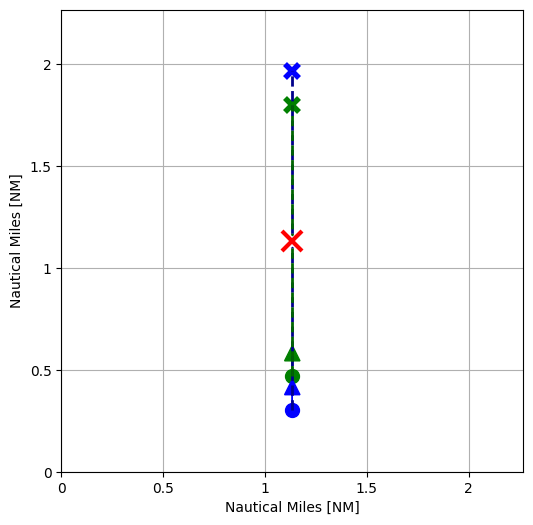

In [8]:
own_ship3 = [{'x': 150, 'y': 40, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 62, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 84, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 106, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 128, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 172, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 194, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 216, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 238, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship3 = [{'x': 150, 'y': 62, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 79.6, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 97.2, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 114.8, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 132.4, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 150, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 167.6, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 185.2, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 202.8, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 220.4, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 238, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa3 = [150, 150]
final_tcpa3 = 11.0
final_dcpa3 = 0.0

mse_ecpa3, mse_cpa3, mse_etcpa3, mse_tcpa3, mse_edcpa3, mse_dcpa3 = compute_mse(own_ship3, target_ship3, final_cpa3, 6, final_tcpa3, final_dcpa3)
overall_mse_ecpa.append(mse_ecpa3)
overall_mse_cpa.append(mse_cpa3)
overall_mse_etcpa.append(mse_etcpa3)
overall_mse_tcpa.append(mse_tcpa3)
overall_mse_edcpa.append(mse_edcpa3)
overall_mse_dcpa.append(mse_dcpa3)

print("MSE eCPA:", mse_ecpa3)
print("MSE CPA:", mse_cpa3)
print("MSE eTCPA:", mse_etcpa3)
print("MSE TCPA:", mse_tcpa3)
print("MSE eDCPA:", mse_edcpa3)
print("MSE DCPA:", mse_dcpa3)

plotting(own_ship3, target_ship3, final_cpa3)

#### Scenario 4

MSE eCPA: 0.0229875521166917
MSE CPA: 0.009525692323764882
MSE eTCPA: 0.00023832030648081033
MSE TCPA: 9.525692323764372e-05
MSE eDCPA: 0.040293597879335966
MSE DCPA: 0.032522747922794006


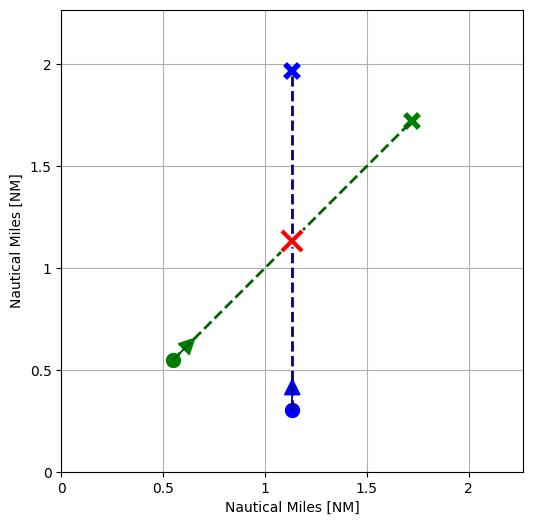

In [9]:
own_ship4 = [{'x': 150, 'y': 40, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 62, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 84, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 106, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 128, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 172, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 194, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 216, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 238, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship4 = [{'x': 72.5, 'y': 72.5, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 88, 'y': 88, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 103.5, 'y': 103.5, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 119, 'y': 119, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 134.5, 'y': 134.5, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 150, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 165.5, 'y': 165.5, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 181, 'y': 181, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 196.5, 'y': 196.5, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 212, 'y': 212, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 227.5, 'y': 227.5, 'COG': 45, 'SOG': 10.0, 'heading': 45, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa4 = [150, 150]
final_tcpa4 = 11.0
final_dcpa4 = 0.0

mse_ecpa4, mse_cpa4, mse_etcpa4, mse_tcpa4, mse_edcpa4, mse_dcpa4 = compute_mse(own_ship4, target_ship4, final_cpa4, 6, final_tcpa4, final_dcpa4)
overall_mse_ecpa.append(mse_ecpa4)
overall_mse_cpa.append(mse_cpa4)
overall_mse_etcpa.append(mse_etcpa4)
overall_mse_tcpa.append(mse_tcpa4)
overall_mse_edcpa.append(mse_edcpa4)
overall_mse_dcpa.append(mse_dcpa4)

print("MSE eCPA:", mse_ecpa4)
print("MSE CPA:", mse_cpa4)
print("MSE eTCPA:", mse_etcpa4)
print("MSE TCPA:", mse_tcpa4)
print("MSE eDCPA:", mse_edcpa4)
print("MSE DCPA:", mse_dcpa4)

plotting(own_ship4, target_ship4, final_cpa4)

#### Scenario 5

MSE eCPA: 353.6859560464447
MSE CPA: 733.6404688363729
MSE eTCPA: 4.548281894748937
MSE TCPA: 7.752670332511327
MSE eDCPA: 185.43001502173163
MSE DCPA: 362.16299233766506


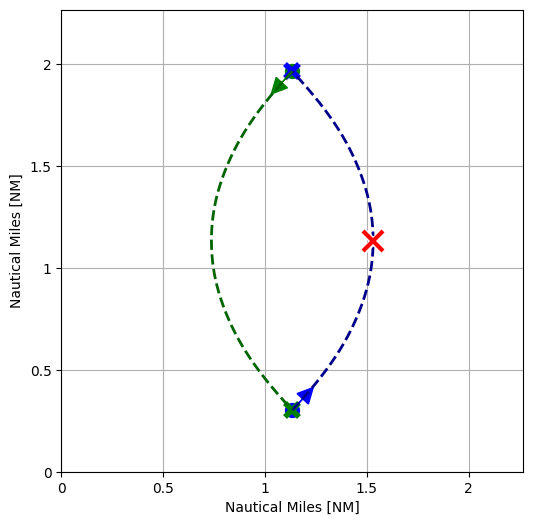

In [10]:
own_ship5 = [{'x': 150, 'y': 40, 'COG': 42.8, 'SOG': 12.5, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 62, 'COG': 38.8, 'SOG': 12.5, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 84, 'COG': 31.8, 'SOG': 12.5, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 106, 'COG': 22.7, 'SOG': 12.5, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 128, 'COG': 12.1, 'SOG': 12.5, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 202.5, 'y': 150, 'COG': 0, 'SOG': 12.5, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 172, 'COG': 347.9, 'SOG': 12.5, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 194, 'COG': 337.3, 'SOG': 12.5, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 216, 'COG': 328.2, 'SOG': 12.5, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 238, 'COG': 321.2, 'SOG': 12.5, 'heading': 321.3, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 317.2, 'SOG': 12.5, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship5 = [{'x': 150, 'y': 260, 'COG': 222.8, 'SOG': 12.5, 'heading': 222.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 131.1, 'y': 238, 'COG': 218.8, 'SOG': 12.5, 'heading': 218.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 116.2, 'y': 216, 'COG': 211.8, 'SOG': 12.5, 'heading': 211.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 105.8, 'y': 194, 'COG': 202.7, 'SOG': 12.5, 'heading': 202.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 99.5, 'y': 172, 'COG': 192.1, 'SOG': 12.5, 'heading': 192.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 97.5, 'y': 150, 'COG': 180, 'SOG': 12.5, 'heading': 180, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 99.5, 'y': 128, 'COG': 167.9, 'SOG': 12.5, 'heading': 167.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 105.8, 'y': 106, 'COG': 157.3, 'SOG': 12.5, 'heading': 157.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 116.2, 'y': 84, 'COG': 148.2, 'SOG': 12.5, 'heading': 148.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 131.1, 'y': 62, 'COG': 141.2, 'SOG': 12.5, 'heading': 141.2, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 40, 'COG': 137.2, 'SOG': 12.5, 'heading': 137.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa5 = [202.5, 150]
final_tcpa5 = 11.0
final_dcpa5 = 105.0

mse_ecpa5, mse_cpa5, mse_etcpa5, mse_tcpa5, mse_edcpa5, mse_dcpa5 = compute_mse(own_ship5, target_ship5, final_cpa5, 6, final_tcpa5, final_dcpa5)
overall_mse_ecpa.append(mse_ecpa5)
overall_mse_cpa.append(mse_cpa5)
overall_mse_etcpa.append(mse_etcpa5)
overall_mse_tcpa.append(mse_tcpa5)
overall_mse_edcpa.append(mse_edcpa5)
overall_mse_dcpa.append(mse_dcpa5)

print("MSE eCPA:", mse_ecpa5)
print("MSE CPA:", mse_cpa5)
print("MSE eTCPA:", mse_etcpa5)
print("MSE TCPA:", mse_tcpa5)
print("MSE eDCPA:", mse_edcpa5)
print("MSE DCPA:", mse_dcpa5)

plotting(own_ship5, target_ship5, final_cpa5)

#### Scenario 6

MSE eCPA: 98.96406723241354
MSE CPA: 267.5242612266182
MSE eTCPA: 0.46162907066053493
MSE TCPA: 0.6262022120545735
MSE eDCPA: 37.735202095541425
MSE DCPA: 242.19282135036957


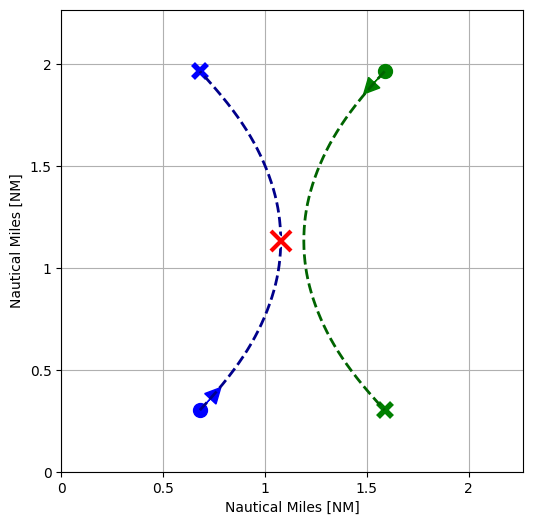

In [11]:
own_ship6 = [{'x': 90, 'y': 40, 'COG': 42.8, 'SOG': 12.5, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 108.9, 'y': 62, 'COG': 38.8, 'SOG': 12.5, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 123.8, 'y': 84, 'COG': 31.8, 'SOG': 12.5, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 134.2, 'y': 106, 'COG': 22.7, 'SOG': 12.5, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 140.5, 'y': 128, 'COG': 12.1, 'SOG': 12.5, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 142.5, 'y': 150, 'COG': 0, 'SOG': 12.5, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 140.5, 'y': 172, 'COG': 347.9, 'SOG': 12.5, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 134.2, 'y': 194, 'COG': 337.3, 'SOG': 12.5, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 123.8, 'y': 216, 'COG': 328.2, 'SOG': 12.5, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 108.9, 'y': 238, 'COG': 321.2, 'SOG': 12.5, 'heading': 321.3, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 90, 'y': 260, 'COG': 317.2, 'SOG': 12.5, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship6 = [{'x': 210, 'y': 260, 'COG': 222.8, 'SOG': 12.5, 'heading': 222.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 191.1, 'y': 238, 'COG': 218.8, 'SOG': 12.5, 'heading': 218.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 176.2, 'y': 216, 'COG': 211.8, 'SOG': 12.5, 'heading': 211.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 165.8, 'y': 194, 'COG': 202.7, 'SOG': 12.5, 'heading': 202.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 159.5, 'y': 172, 'COG': 192.1, 'SOG': 12.5, 'heading': 192.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 157.5, 'y': 150, 'COG': 180, 'SOG': 12.5, 'heading': 180, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 159.5, 'y': 128, 'COG': 167.9, 'SOG': 12.5, 'heading': 167.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 165.8, 'y': 106, 'COG': 157.3, 'SOG': 12.5, 'heading': 157.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 176.2, 'y': 84, 'COG': 148.2, 'SOG': 12.5, 'heading': 148.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 191.1, 'y': 62, 'COG': 141.2, 'SOG': 12.5, 'heading': 141.2, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 210, 'y': 40, 'COG': 137.2, 'SOG': 12.5, 'heading': 137.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa6 = [142.5, 150]
final_tcpa6 = 11.0
final_dcpa6 = 15.0

mse_ecpa6, mse_cpa6, mse_etcpa6, mse_tcpa6, mse_edcpa6, mse_dcpa6 = compute_mse(own_ship6, target_ship6, final_cpa6, 6, final_tcpa6, final_dcpa6)
overall_mse_ecpa.append(mse_ecpa6)
overall_mse_cpa.append(mse_cpa6)
overall_mse_etcpa.append(mse_etcpa6)
overall_mse_tcpa.append(mse_tcpa6)
overall_mse_edcpa.append(mse_edcpa6)
overall_mse_dcpa.append(mse_dcpa6)

print("MSE eCPA:", mse_ecpa6)
print("MSE CPA:", mse_cpa6)
print("MSE eTCPA:", mse_etcpa6)
print("MSE TCPA:", mse_tcpa6)
print("MSE eDCPA:", mse_edcpa6)
print("MSE DCPA:", mse_dcpa6)

plotting(own_ship6, target_ship6, final_cpa6)

#### Scenario 7

MSE eCPA: 355.03031568429236
MSE CPA: 735.0099823895941
MSE eTCPA: 4.221846007480876
MSE TCPA: 7.311001894326904
MSE eDCPA: 1.8864260206841628
MSE DCPA: 3.6582566978270163


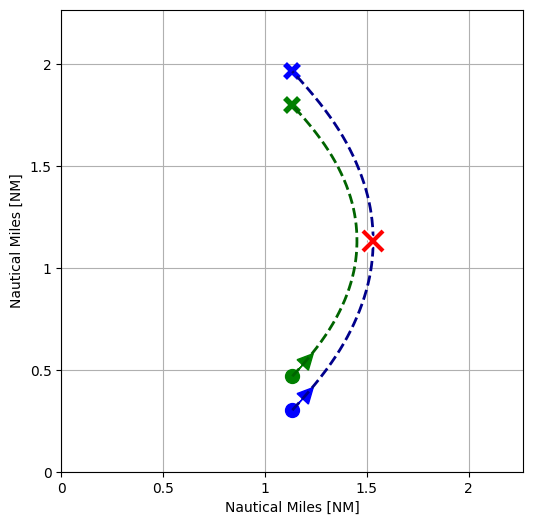

In [12]:
own_ship7 = [{'x': 150, 'y': 40, 'COG': 42.8, 'SOG': 12.5, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 62, 'COG': 38.8, 'SOG': 12.5, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 84, 'COG': 31.8, 'SOG': 12.5, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 106, 'COG': 22.7, 'SOG': 12.5, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 128, 'COG': 12.1, 'SOG': 12.5, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 202.5, 'y': 150, 'COG': 0, 'SOG': 12.5, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 172, 'COG': 347.9, 'SOG': 12.5, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 194, 'COG': 337.3, 'SOG': 12.5, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 216, 'COG': 328.2, 'SOG': 12.5, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 238, 'COG': 321.2, 'SOG': 12.5, 'heading': 321.3, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 317.2, 'SOG': 12.5, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship7 = [{'x': 150, 'y': 62, 'COG': 42.8, 'SOG': 10.0, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 165.1, 'y': 79.6, 'COG': 38.8, 'SOG': 10.0, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 177, 'y': 97.2, 'COG': 31.8, 'SOG': 10.0, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 185.4, 'y': 114.8, 'COG': 22.7, 'SOG': 10.0, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 190.4, 'y': 132.4, 'COG': 12.1, 'SOG': 10.0, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 192, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 190.4, 'y': 167.6, 'COG': 347.9, 'SOG': 10.0, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 185.4, 'y': 185.2, 'COG': 337.3, 'SOG': 10.0, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 177, 'y': 202.8, 'COG': 328.2, 'SOG': 10.0, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 165.1, 'y': 220.4, 'COG': 321.2, 'SOG': 10.0, 'heading': 321.3, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 238, 'COG': 317.2, 'SOG': 10.0, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa7 = [202.5, 150]
final_tcpa7 = 10.9
final_dcpa7 = 10.5

mse_ecpa7, mse_cpa7, mse_etcpa7, mse_tcpa7, mse_edcpa7, mse_dcpa7 = compute_mse(own_ship7, target_ship7, final_cpa7, 6, final_tcpa7, final_dcpa7)
overall_mse_ecpa.append(mse_ecpa7)
overall_mse_cpa.append(mse_cpa7)
overall_mse_etcpa.append(mse_etcpa7)
overall_mse_tcpa.append(mse_tcpa7)
overall_mse_edcpa.append(mse_edcpa7)
overall_mse_dcpa.append(mse_dcpa7)

print("MSE eCPA:", mse_ecpa7)
print("MSE CPA:", mse_cpa7)
print("MSE eTCPA:", mse_etcpa7)
print("MSE TCPA:", mse_tcpa7)
print("MSE eDCPA:", mse_edcpa7)
print("MSE DCPA:", mse_dcpa7)

plotting(own_ship7, target_ship7, final_cpa7)

#### Scenario 8

MSE eCPA: 1208.2393208154042
MSE CPA: 56838.92977969461
MSE eTCPA: 1.6602851652593336
MSE TCPA: 291.3532396346936
MSE eDCPA: 65.92281216465143
MSE DCPA: 4.6159632396932345e-28


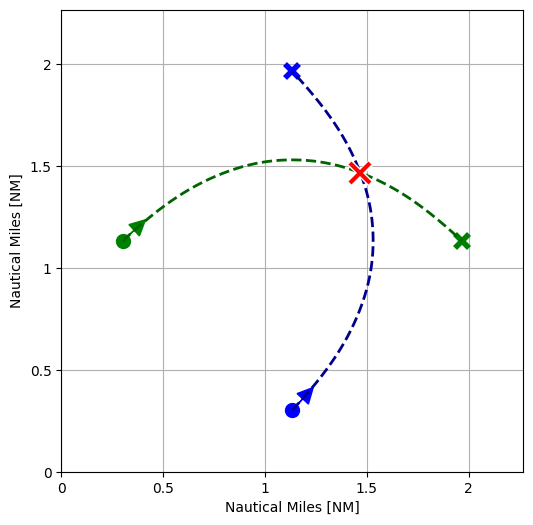

In [13]:
own_ship8 = [{'x': 150, 'y': 40, 'COG': 42.8, 'SOG': 12.5, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 62, 'COG': 38.8, 'SOG': 12.5, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 84, 'COG': 31.8, 'SOG': 12.5, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 106, 'COG': 22.7, 'SOG': 12.5, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 128, 'COG': 12.1, 'SOG': 12.5, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 202.5, 'y': 150, 'COG': 0, 'SOG': 12.5, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 172, 'COG': 347.9, 'SOG': 12.5, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 194, 'COG': 337.3, 'SOG': 12.5, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 216, 'COG': 328.2, 'SOG': 12.5, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 238, 'COG': 321.2, 'SOG': 12.5, 'heading': 321.2, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 317.2, 'SOG': 12.5, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship8 = [{'x': 40, 'y': 150, 'COG': 47.2, 'SOG': 12.5, 'heading': 47.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 62, 'y': 168.9, 'COG': 51.2, 'SOG': 12.5, 'heading': 51.2, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 84, 'y': 183.8, 'COG': 58.2, 'SOG': 12.5, 'heading': 58.2, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 106, 'y': 194.2, 'COG': 67.3, 'SOG': 12.5, 'heading': 67.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 128, 'y': 200.5, 'COG': 77.9, 'SOG': 12.5, 'heading': 77.9, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 202.5, 'COG': 90, 'SOG': 12.5, 'heading': 90, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 172, 'y': 200.5, 'COG': 102.1, 'SOG': 12.5, 'heading': 102.1, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 194, 'y': 194.2, 'COG': 112.7, 'SOG': 12.5, 'heading': 112.7, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 216, 'y': 183.8, 'COG': 121.8, 'SOG': 12.5, 'heading': 121.8, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 238, 'y': 168.9, 'COG': 128.8, 'SOG': 12.5, 'heading': 128.8, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 260, 'y': 150, 'COG': 132.8, 'SOG': 12.5, 'heading': 132.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa8 = [194.1, 194.1]
final_tcpa8 = 15.4
final_dcpa8 = 0.0

mse_ecpa8, mse_cpa8, mse_etcpa8, mse_tcpa8, mse_edcpa8, mse_dcpa8 = compute_mse(own_ship8, target_ship8, final_cpa8, 8, final_tcpa8, final_dcpa8)
overall_mse_ecpa.append(mse_ecpa8)
overall_mse_cpa.append(mse_cpa8)
overall_mse_etcpa.append(mse_etcpa8)
overall_mse_tcpa.append(mse_tcpa8)
overall_mse_edcpa.append(mse_edcpa8)
overall_mse_dcpa.append(mse_dcpa8)

print("MSE eCPA:", mse_ecpa8)
print("MSE CPA:", mse_cpa8)
print("MSE eTCPA:", mse_etcpa8)
print("MSE TCPA:", mse_tcpa8)
print("MSE eDCPA:", mse_edcpa8)
print("MSE DCPA:", mse_dcpa8)

plotting(own_ship8, target_ship8, final_cpa8)

#### Scenario 9

MSE eCPA: 576.7020120438425
MSE CPA: 1525.6001723568334
MSE eTCPA: 4.670301363853997
MSE TCPA: 10.962882780719966
MSE eDCPA: 233.8684740504777
MSE DCPA: 552.6320248982066


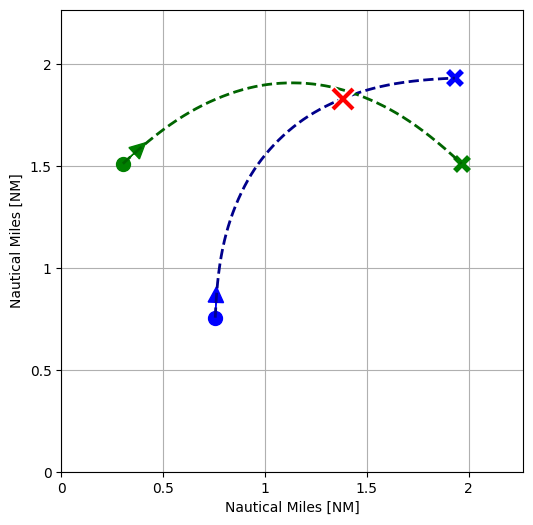

In [14]:
own_ship9 = [{'x': 100, 'y': 100, 'COG': 2.2, 'SOG': 12.5, 'heading': 2.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 102.2, 'y': 128.9, 'COG': 6.2, 'SOG': 12.5, 'heading': 6.2, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 107.2, 'y': 155, 'COG': 13.2, 'SOG': 12.5, 'heading': 13.2, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 115.4, 'y': 177.9, 'COG': 22.3, 'SOG': 12.5, 'heading': 22.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 126.5, 'y': 197.9, 'COG': 32.9, 'SOG': 12.5, 'heading': 32.9, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 140.7, 'y': 214.9, 'COG': 45, 'SOG': 12.5, 'heading': 45, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 157.6, 'y': 229, 'COG': 57.1, 'SOG': 12.5, 'heading': 57.1, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 177.6, 'y': 240.1, 'COG': 67.7, 'SOG': 12.5, 'heading': 67.7, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.6, 'y': 248.4, 'COG': 76.8, 'SOG': 12.5, 'heading': 76.8, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 226.6, 'y': 253.4, 'COG': 83.8, 'SOG': 12.5, 'heading': 83.8, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 255.6, 'y': 255.6, 'COG': 87.8, 'SOG': 12.5, 'heading': 87.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship9 = [{'x': 40, 'y': 200, 'COG': 47.2, 'SOG': 12.5, 'heading': 47.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 62, 'y': 218.9, 'COG': 51.2, 'SOG': 12.5, 'heading': 51.2, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 84, 'y': 233.8, 'COG': 58.2, 'SOG': 12.5, 'heading': 58.2, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 106, 'y': 244.2, 'COG': 67.3, 'SOG': 12.5, 'heading': 67.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 128, 'y': 250.5, 'COG': 77.9, 'SOG': 12.5, 'heading': 77.9, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 252.5, 'COG': 90, 'SOG': 12.5, 'heading': 90, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 172, 'y': 250.5, 'COG': 102.1, 'SOG': 12.5, 'heading': 102.1, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 194, 'y': 244.2, 'COG': 112.7, 'SOG': 12.5, 'heading': 112.7, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 216, 'y': 233.8, 'COG': 121.8, 'SOG': 12.5, 'heading': 121.8, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 238, 'y': 218.9, 'COG': 128.8, 'SOG': 12.5, 'heading': 128.8, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 260, 'y': 200, 'COG': 132.8, 'SOG': 12.5, 'heading': 132.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa9 = [182.7, 242.3]
final_tcpa9 = 15.9
final_dcpa9 = 16.4

mse_ecpa9, mse_cpa9, mse_etcpa9, mse_tcpa9, mse_edcpa9, mse_dcpa9 = compute_mse(own_ship9, target_ship9, final_cpa9, 8, final_tcpa9, final_dcpa9)
overall_mse_ecpa.append(mse_ecpa9)
overall_mse_cpa.append(mse_cpa9)
overall_mse_etcpa.append(mse_etcpa9)
overall_mse_tcpa.append(mse_tcpa9)
overall_mse_edcpa.append(mse_edcpa9)
overall_mse_dcpa.append(mse_dcpa9)

print("MSE eCPA:", mse_ecpa9)
print("MSE CPA:", mse_cpa9)
print("MSE eTCPA:", mse_etcpa9)
print("MSE TCPA:", mse_tcpa9)
print("MSE eDCPA:", mse_edcpa9)
print("MSE DCPA:", mse_dcpa9)

plotting(own_ship9, target_ship9, final_cpa9)

#### Scenario 10

MSE eCPA: 6673.171438229882
MSE CPA: 1831523.0604062327
MSE eTCPA: 29.299669440240084
MSE TCPA: 12226.342945817476
MSE eDCPA: 16429.193525037626
MSE DCPA: 3.41068394932889e-27


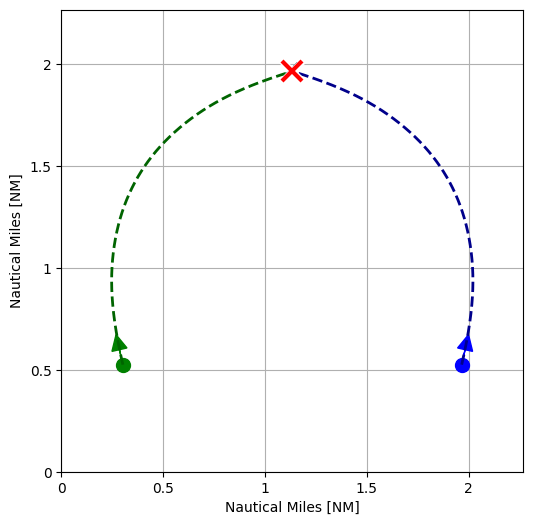

In [15]:
own_ship10 = [{'x': 260, 'y': 69.5, 'COG': 12.8, 'SOG': 12.5, 'heading': 12.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 265.4, 'y': 98, 'COG': 8.8, 'SOG': 12.5, 'heading': 8.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 267.3, 'y': 124.5, 'COG': 1.8, 'SOG': 12.5, 'heading': 1.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 265.3, 'y': 148.7, 'COG': 352.7, 'SOG': 12.5, 'heading': 352.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 259.7, 'y': 170.9, 'COG': 342.1, 'SOG': 12.5, 'heading': 342.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 250.5, 'y': 191, 'COG': 330, 'SOG': 12.5, 'heading': 330, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 237.7, 'y': 209, 'COG': 317.9, 'SOG': 12.5, 'heading': 317.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 221.3, 'y': 224.9, 'COG': 307.3, 'SOG': 12.5, 'heading': 307.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 201.3, 'y': 238.8, 'COG': 298.2, 'SOG': 12.5, 'heading': 298.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 177.4, 'y': 250.4, 'COG': 291.2, 'SOG': 12.5, 'heading': 291.2, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 287.2, 'SOG': 12.5, 'heading': 287.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship10 = [{'x': 40, 'y': 69.5, 'COG': 347.2, 'SOG': 12.5, 'heading': 347.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 34.6, 'y': 98, 'COG': 351.2, 'SOG': 12.5, 'heading': 351.2, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 32.7, 'y': 124.5, 'COG': 358.2, 'SOG': 12.5, 'heading': 358.2, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 34.7, 'y': 148.7, 'COG': 7.3, 'SOG': 12.5, 'heading': 7.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 40.3, 'y': 170.9, 'COG': 17.9, 'SOG': 12.5, 'heading': 17.9, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 49.5, 'y': 191, 'COG': 30, 'SOG': 12.5, 'heading': 30, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 62.3, 'y': 209, 'COG': 42.1, 'SOG': 12.5, 'heading': 42.1, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 78.7, 'y': 224.9, 'COG': 52.7, 'SOG': 12.5, 'heading': 52.7, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 98.7, 'y': 238.8, 'COG': 61.8, 'SOG': 12.5, 'heading': 61.8, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 122.6, 'y': 250.4, 'COG': 68.8, 'SOG': 12.5, 'heading': 68.8, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 260, 'COG': 72.8, 'SOG': 12.5, 'heading': 72.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa10 = [150, 260]
final_tcpa10 = 22.0
final_dcpa10 = 0.0

mse_ecpa10, mse_cpa10, mse_etcpa10, mse_tcpa10, mse_edcpa10, mse_dcpa10 = compute_mse(own_ship10, target_ship10, final_cpa10, 10, final_tcpa10, final_dcpa10)
overall_mse_ecpa.append(mse_ecpa10)
overall_mse_cpa.append(mse_cpa10)
overall_mse_etcpa.append(mse_etcpa10)
overall_mse_tcpa.append(mse_tcpa10)
overall_mse_edcpa.append(mse_edcpa10)
overall_mse_dcpa.append(mse_dcpa10)

print("MSE eCPA:", mse_ecpa10)
print("MSE CPA:", mse_cpa10)
print("MSE eTCPA:", mse_etcpa10)
print("MSE TCPA:", mse_tcpa10)
print("MSE eDCPA:", mse_edcpa10)
print("MSE DCPA:", mse_dcpa10)

plotting(own_ship10, target_ship10, final_cpa10)

### Intermediate Results of only the Scenarios with Constant Speed

In [16]:
print("Cumulative Overall MSE eCPA:", np.sum(overall_mse_ecpa))
print("Cumulative Overall MSE CPA:", np.sum(overall_mse_cpa))
print("Average Overall MSE eCPA:", np.mean(overall_mse_ecpa))
print("Average Overall MSE CPA:", np.mean(overall_mse_cpa), "\n")

print("Cumulative Overall MSE eTCPA:", np.sum(overall_mse_etcpa))
print("Cumulative Overall MSE TCPA:", np.sum(overall_mse_tcpa))
print("Average Overall MSE eTCPA:", np.mean(overall_mse_etcpa))
print("Average Overall MSE TCPA:", np.mean(overall_mse_tcpa), "\n")

print("Cumulative Overall MSE eDCPA:", np.sum(overall_mse_edcpa))
print("Cumulative Overall MSE DCPA:", np.sum(overall_mse_dcpa))
print("Average Overall MSE eDCPA:", np.mean(overall_mse_edcpa))
print("Average Overall MSE DCPA:", np.mean(overall_mse_dcpa), "\n")

# Check the length of the overall lists; must be the same as the number of scenarios
print("Length of eCPA List:", len(overall_mse_ecpa), " ---> ", len(overall_mse_ecpa) == 10)
print("Length of CPA List:", len(overall_mse_cpa), " ---> ", len(overall_mse_cpa) == 10)
print("Length of eTCPA List:", len(overall_mse_etcpa), " ---> ", len(overall_mse_etcpa) == 10)
print("Length of TCPA List:", len(overall_mse_tcpa), " ---> ", len(overall_mse_tcpa) == 10)
print("Length of eDCPA List:", len(overall_mse_edcpa), " ---> ", len(overall_mse_edcpa) == 10)
print("Length of DCPA List:", len(overall_mse_dcpa), " ---> ", len(overall_mse_dcpa) == 10)

Cumulative Overall MSE eCPA: 9265.945293466926
Cumulative Overall MSE CPA: 1891623.774596429
Average Overall MSE eCPA: 926.5945293466926
Average Overall MSE CPA: 189162.37745964288 

Cumulative Overall MSE eTCPA: 44.86380006255024
Cumulative Overall MSE TCPA: 12544.349037928705
Average Overall MSE eTCPA: 4.486380006255024
Average Overall MSE TCPA: 1254.4349037928705 

Cumulative Overall MSE eDCPA: 16954.102525085007
Cumulative Overall MSE DCPA: 1160.6786180319912
Average Overall MSE eDCPA: 1695.4102525085007
Average Overall MSE DCPA: 116.06786180319912 

Length of eCPA List: 10  --->  True
Length of CPA List: 10  --->  True
Length of eTCPA List: 10  --->  True
Length of TCPA List: 10  --->  True
Length of eDCPA List: 10  --->  True
Length of DCPA List: 10  --->  True


### Scenarios with Varying Speed

#### Ressources for those Scenarios

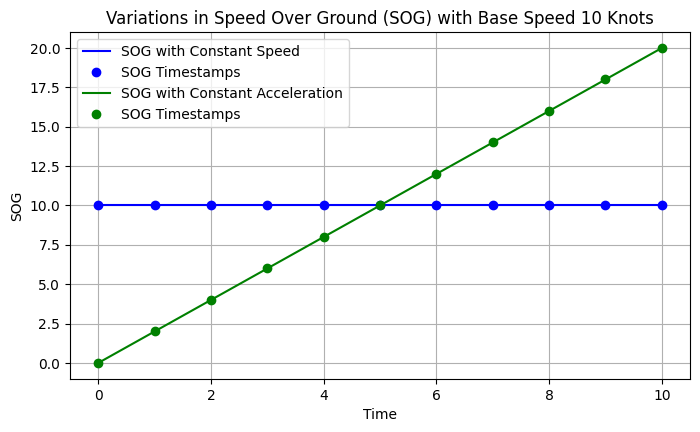

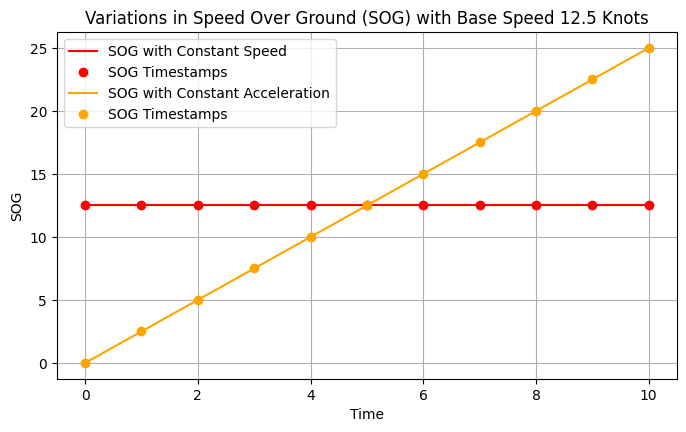

In [17]:
# SOG with base speed 8
sog_8_const = [0, 1.6, 3.2, 4.8, 6.4, 8, 9.6, 11.2, 12.8, 14.4, 16]

# SOG with base speed 10
sog_10_const = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

# SOG with base speed 12.5
sog_12_5_const = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]

# Plot of the varying SOG data with base 10
plt.figure(figsize=(8, 4.5))
plt.plot(np.arange(11), [10] * 11, color='blue', label='SOG with Constant Speed')
plt.plot(np.arange(11), [10] * 11, 'o', color='blue', label='SOG Timestamps')
plt.plot(np.arange(11), sog_10_const, color='green', label='SOG with Constant Acceleration')
plt.plot(np.arange(11), sog_10_const, 'o', color='green', label='SOG Timestamps')
plt.xlabel('Time')
plt.ylabel('SOG')
plt.title('Variations in Speed Over Ground (SOG) with Base Speed 10 Knots')
plt.grid()
plt.legend()
plt.show()

# Plot of the varying SOG data with base 12.5
plt.figure(figsize=(8, 4.5))
plt.plot(np.arange(11), [12.5] * 11, color='red', label='SOG with Constant Speed')
plt.plot(np.arange(11), [12.5] * 11, 'o', color='red', label='SOG Timestamps')
plt.plot(np.arange(11), sog_12_5_const, color='orange', label='SOG with Constant Acceleration')
plt.plot(np.arange(11), sog_12_5_const, 'o', color='orange', label='SOG Timestamps')
plt.xlabel('Time')
plt.ylabel('SOG')
plt.title('Variations in Speed Over Ground (SOG) with Base Speed 12.5 Knots')
plt.grid()
plt.legend()
plt.show()

#### Scenario 11

MSE eCPA: 0.01336908146051115
MSE CPA: 576.1370142808302
MSE eTCPA: 0.0004049559576120652
MSE TCPA: 5.66281758148074
MSE eDCPA: 0.0033117322825125368
MSE DCPA: 0.04000000000000001


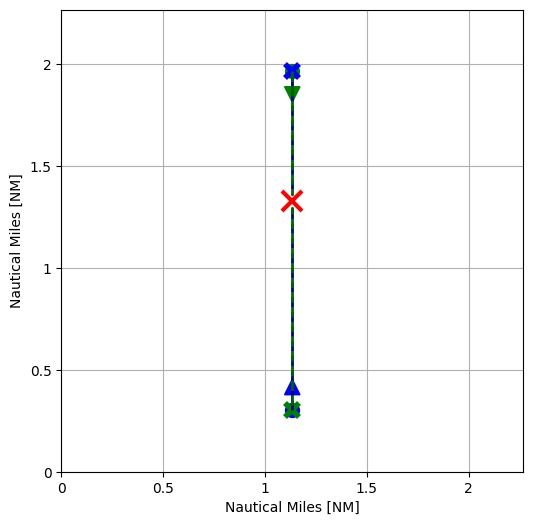

In [18]:
own_ship11 = [{'x': 150, 'y': 40, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 62, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 84, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 106, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 128, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 172, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 194, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 216, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 238, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship11 = [{'x': 150.0, 'y': 260.0, 'COG': 180, 'SOG': 0, 'heading': 180, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 257.8, 'COG': 180.0, 'SOG': 2, 'heading': 180.0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 251.2, 'COG': 180.0, 'SOG': 4, 'heading': 180.0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 240.2, 'COG': 180.0, 'SOG': 6, 'heading': 180.0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 224.8, 'COG': 180.0, 'SOG': 8, 'heading': 180.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 204.9, 'COG': 180.0, 'SOG': 10, 'heading': 180.0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 180.7, 'COG': 180.0, 'SOG': 12, 'heading': 180.0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 152.1, 'COG': 180.0, 'SOG': 14, 'heading': 180.0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 119.1, 'COG': 180.0, 'SOG': 16, 'heading': 180.0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 81.6, 'COG': 180.0, 'SOG': 18, 'heading': 180.0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 40.0, 'COG': 180, 'SOG': 20, 'heading': 180, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa11 = [150, 175.7]
final_tcpa11 = 13.6
final_dcpa11 = 0.2

mse_ecpa11, mse_cpa11, mse_etcpa11, mse_tcpa11, mse_edcpa11, mse_dcpa11 = compute_mse(own_ship11, target_ship11, final_cpa11, 7, final_tcpa11, final_dcpa11)
overall_mse_ecpa.append(mse_ecpa11)
overall_mse_cpa.append(mse_cpa11)
overall_mse_etcpa.append(mse_etcpa11)
overall_mse_tcpa.append(mse_tcpa11)
overall_mse_edcpa.append(mse_edcpa11)
overall_mse_dcpa.append(mse_dcpa11)

print("MSE eCPA:", mse_ecpa11)
print("MSE CPA:", mse_cpa11)
print("MSE eTCPA:", mse_etcpa11)
print("MSE TCPA:", mse_tcpa11)
print("MSE eDCPA:", mse_edcpa11)
print("MSE DCPA:", mse_dcpa11)

plotting(own_ship11, target_ship11, final_cpa11)

#### Scenario 12

MSE eCPA: 0.376315922195098
MSE CPA: 25.21229143574533
MSE eTCPA: 0.0033996557610666447
MSE TCPA: 0.2521229143574536
MSE eDCPA: 0.004414530784686778
MSE DCPA: 713.3025561673072


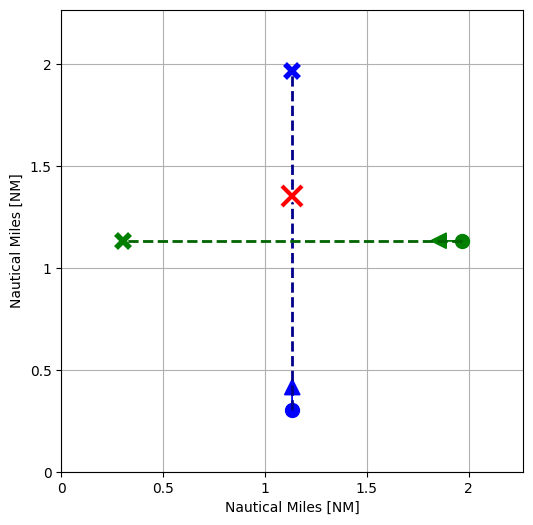

In [19]:
own_ship12 = [{'x': 150, 'y': 40, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 62, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 84, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 106, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 128, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 172, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 194, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 216, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 238, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship12 = [{'x': 260.0, 'y': 150.0, 'COG': 270, 'SOG': 0, 'heading': 270, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 257.8, 'y': 150.0, 'COG': 270.0, 'SOG': 2, 'heading': 270.0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 251.2, 'y': 150.0, 'COG': 270.0, 'SOG': 4, 'heading': 270.0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 240.2, 'y': 150.0, 'COG': 270.0, 'SOG': 6, 'heading': 270.0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 224.8, 'y': 150.0, 'COG': 270.0, 'SOG': 8, 'heading': 270.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 204.9, 'y': 150.0, 'COG': 270.0, 'SOG': 10, 'heading': 270.0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 180.7, 'y': 150.0, 'COG': 270.0, 'SOG': 12, 'heading': 270.0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 152.1, 'y': 150.0, 'COG': 270.0, 'SOG': 14, 'heading': 270.0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 119.1, 'y': 150.0, 'COG': 270.0, 'SOG': 16, 'heading': 270.0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 81.6, 'y': 150.0, 'COG': 270.0, 'SOG': 18, 'heading': 270.0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 40.0, 'y': 150.0, 'COG': 270, 'SOG': 20, 'heading': 270, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa12 = [150, 179]
final_tcpa12 = 13.9
final_dcpa12 = 36.1

mse_ecpa12, mse_cpa12, mse_etcpa12, mse_tcpa12, mse_edcpa12, mse_dcpa12 = compute_mse(own_ship12, target_ship12, final_cpa12, 7, final_tcpa12, final_dcpa12)
overall_mse_ecpa.append(mse_ecpa12)
overall_mse_cpa.append(mse_cpa12)
overall_mse_etcpa.append(mse_etcpa12)
overall_mse_tcpa.append(mse_tcpa12)
overall_mse_edcpa.append(mse_edcpa12)
overall_mse_dcpa.append(mse_dcpa12)

print("MSE eCPA:", mse_ecpa12)
print("MSE CPA:", mse_cpa12)
print("MSE eTCPA:", mse_etcpa12)
print("MSE TCPA:", mse_tcpa12)
print("MSE eDCPA:", mse_edcpa12)
print("MSE DCPA:", mse_dcpa12)

plotting(own_ship12, target_ship12, final_cpa12)

#### Scenario 13

MSE eCPA: 339.5181348831467
MSE CPA: nan
MSE eTCPA: 1.169048234924407
MSE TCPA: inf
MSE eDCPA: 96.88013376758568
MSE DCPA: nan


/data1/sgao/repos/enhanced-cpa/cpapy/eCPA/tests/standard_cpa.py:44: RuntimeWarning: invalid value encountered in subtract
  cpa_distance = np.linalg.norm(np.asarray(cpa[0]) - np.asarray(cpa[1]))


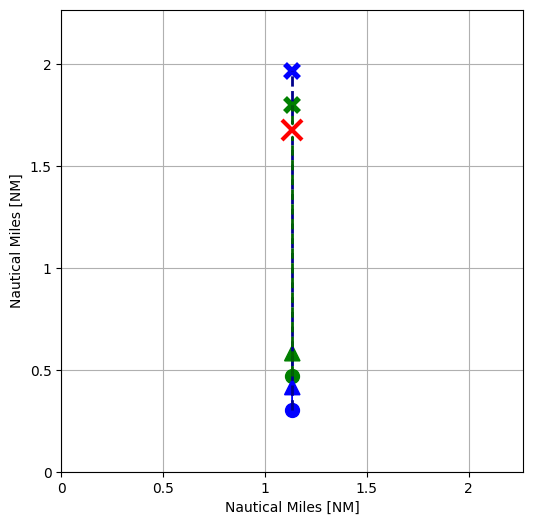

In [20]:
own_ship13 = [{'x': 150.0, 'y': 40.0, 'COG': 0, 'SOG': 0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 42.2, 'COG': 0.0, 'SOG': 2, 'heading': 0.0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 48.8, 'COG': 0.0, 'SOG': 4, 'heading': 0.0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 59.8, 'COG': 0.0, 'SOG': 6, 'heading': 0.0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 75.2, 'COG': 0.0, 'SOG': 8, 'heading': 0.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 95.1, 'COG': 0.0, 'SOG': 10, 'heading': 0.0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 119.3, 'COG': 0.0, 'SOG': 12, 'heading': 0.0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 147.9, 'COG': 0.0, 'SOG': 14, 'heading': 0.0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 180.9, 'COG': 0.0, 'SOG': 16, 'heading': 0.0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 218.4, 'COG': 0.0, 'SOG': 18, 'heading': 0.0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 260.0, 'COG': 0, 'SOG': 20, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship13 = [{'x': 150, 'y': 62, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 79.6, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 97.2, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 114.8, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 132.4, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 150, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 167.6, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 185.2, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 202.8, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 220.4, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 238, 'COG': 0, 'SOG': 8.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa13 = [150, 221.7]
final_tcpa13 = 20.0
final_dcpa13 = 0.1

mse_ecpa13, mse_cpa13, mse_etcpa13, mse_tcpa13, mse_edcpa13, mse_dcpa13 = compute_mse(own_ship13, target_ship13, final_cpa13, 6, final_tcpa13, final_dcpa13)
overall_mse_ecpa.append(mse_ecpa13)
overall_mse_cpa.append(mse_cpa13)
overall_mse_etcpa.append(mse_etcpa13)
overall_mse_tcpa.append(mse_tcpa13)
overall_mse_edcpa.append(mse_edcpa13)
overall_mse_dcpa.append(mse_dcpa13)

print("MSE eCPA:", mse_ecpa13)
print("MSE CPA:", mse_cpa13)
print("MSE eTCPA:", mse_etcpa13)
print("MSE TCPA:", mse_tcpa13)
print("MSE eDCPA:", mse_edcpa13)
print("MSE DCPA:", mse_dcpa13)

plotting(own_ship13, target_ship13, final_cpa13)

#### Scenario 14

MSE eCPA: 0.2350360871381906
MSE CPA: 4089.7148577020384
MSE eTCPA: 0.0037149870722273
MSE TCPA: 41.43514819284247
MSE eDCPA: 0.03999118521117029
MSE DCPA: 291.17738121283355


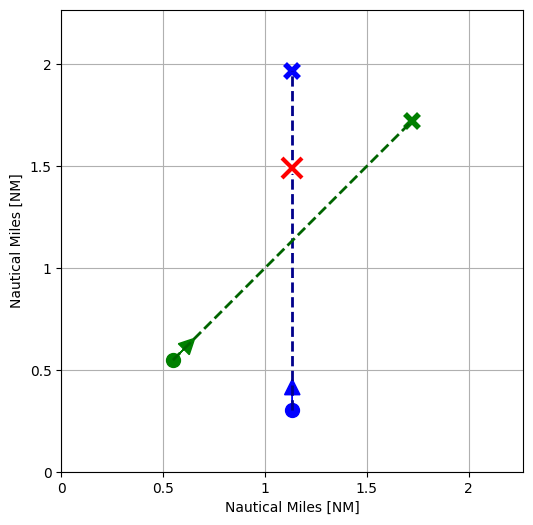

In [21]:
own_ship14 = [{'x': 150, 'y': 40, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 62, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 84, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 106, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 128, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 172, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 194, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 216, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 238, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship14 = [{'x': 72.5, 'y': 72.5, 'COG': 45, 'SOG': 0, 'heading': 45, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 74.1, 'y': 74.1, 'COG': 45.0, 'SOG': 2, 'heading': 45.0, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 78.7, 'y': 78.7, 'COG': 45.0, 'SOG': 4, 'heading': 45.0, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 86.5, 'y': 86.5, 'COG': 45.0, 'SOG': 6, 'heading': 45.0, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 97.3, 'y': 97.3, 'COG': 45.0, 'SOG': 8, 'heading': 45.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 111.3, 'y': 111.3, 'COG': 45.0, 'SOG': 10, 'heading': 45.0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 128.4, 'y': 128.4, 'COG': 45.0, 'SOG': 12, 'heading': 45.0, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 148.5, 'y': 148.5, 'COG': 45.0, 'SOG': 14, 'heading': 45.0, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 171.6, 'y': 171.6, 'COG': 45.0, 'SOG': 16, 'heading': 45.0, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 198.0, 'y': 198.0, 'COG': 45.0, 'SOG': 18, 'heading': 45.0, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 227.5, 'y': 227.5, 'COG': 45, 'SOG': 20, 'heading': 45, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa14 = [150, 197.5]
final_tcpa14 = 15.8
final_dcpa14 = 45.3

mse_ecpa14, mse_cpa14, mse_etcpa14, mse_tcpa14, mse_edcpa14, mse_dcpa14 = compute_mse(own_ship14, target_ship14, final_cpa14, 7, final_tcpa14, final_dcpa14)
overall_mse_ecpa.append(mse_ecpa14)
overall_mse_cpa.append(mse_cpa14)
overall_mse_etcpa.append(mse_etcpa14)
overall_mse_tcpa.append(mse_tcpa14)
overall_mse_edcpa.append(mse_edcpa14)
overall_mse_dcpa.append(mse_dcpa14)

print("MSE eCPA:", mse_ecpa14)
print("MSE CPA:", mse_cpa14)
print("MSE eTCPA:", mse_etcpa14)
print("MSE TCPA:", mse_tcpa14)
print("MSE eDCPA:", mse_edcpa14)
print("MSE DCPA:", mse_dcpa14)

plotting(own_ship14, target_ship14, final_cpa14)

#### Scenario 15

MSE eCPA: 343.359498326247
MSE CPA: 665.2283253609102
MSE eTCPA: 4.119591464339439
MSE TCPA: 2.9881589312198997
MSE eDCPA: 291.19545027101407
MSE DCPA: 524.9876996829547


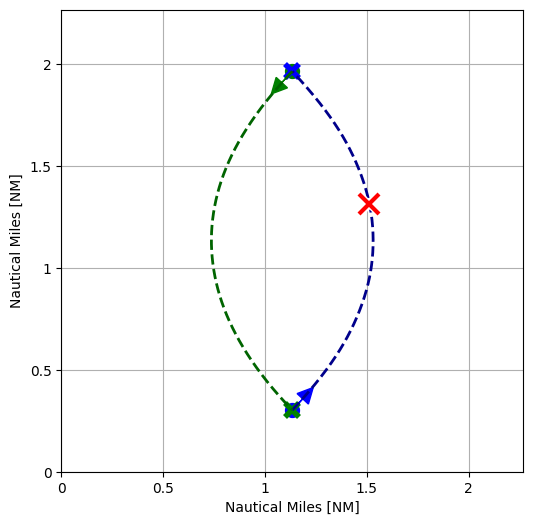

In [22]:
own_ship15 = [{'x': 150, 'y': 40, 'COG': 42.8, 'SOG': 12.5, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 62, 'COG': 38.8, 'SOG': 12.5, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 84, 'COG': 31.8, 'SOG': 12.5, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 106, 'COG': 22.7, 'SOG': 12.5, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 128, 'COG': 12.1, 'SOG': 12.5, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 202.5, 'y': 150, 'COG': 0, 'SOG': 12.5, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 172, 'COG': 347.9, 'SOG': 12.5, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 194, 'COG': 337.3, 'SOG': 12.5, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 216, 'COG': 328.2, 'SOG': 12.5, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 238, 'COG': 321.2, 'SOG': 12.5, 'heading': 321.3, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 317.2, 'SOG': 12.5, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship15 = [{'x': 150.0, 'y': 260.0, 'COG': 222.8, 'SOG': 0, 'heading': 222.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 148.1, 'y': 258.0, 'COG': 222.6, 'SOG': 2.5, 'heading': 222.6, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 143.1, 'y': 252.4, 'COG': 221.5, 'SOG': 5, 'heading': 221.5, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 135.0, 'y': 242.9, 'COG': 219.3, 'SOG': 7.5, 'heading': 219.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 124.6, 'y': 229.1, 'COG': 215.0, 'SOG': 10, 'heading': 215.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 112.9, 'y': 209.9, 'COG': 207.3, 'SOG': 12.5, 'heading': 207.3, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 102.5, 'y': 184.4, 'COG': 196.8, 'SOG': 15, 'heading': 196.8, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 97.5, 'y': 152.4, 'COG': 181.1, 'SOG': 17.5, 'heading': 181.1, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 102.6, 'y': 115.3, 'COG': 163.2, 'SOG': 20, 'heading': 163.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 120.5, 'y': 76.9, 'COG': 147.4, 'SOG': 22.5, 'heading': 147.4, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 40.0, 'COG': 137.2, 'SOG': 25, 'heading': 137.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa15 = [200.1, 174]
final_tcpa15 = 13.4
final_dcpa15 = 98.7

mse_ecpa15, mse_cpa15, mse_etcpa15, mse_tcpa15, mse_edcpa15, mse_dcpa15 = compute_mse(own_ship15, target_ship15, final_cpa15, 7, final_tcpa15, final_dcpa15)
overall_mse_ecpa.append(mse_ecpa15)
overall_mse_cpa.append(mse_cpa15)
overall_mse_etcpa.append(mse_etcpa15)
overall_mse_tcpa.append(mse_tcpa15)
overall_mse_edcpa.append(mse_edcpa15)
overall_mse_dcpa.append(mse_dcpa15)

print("MSE eCPA:", mse_ecpa15)
print("MSE CPA:", mse_cpa15)
print("MSE eTCPA:", mse_etcpa15)
print("MSE TCPA:", mse_tcpa15)
print("MSE eDCPA:", mse_edcpa15)
print("MSE DCPA:", mse_dcpa15)

plotting(own_ship15, target_ship15, final_cpa15)

#### Scenario 16

MSE eCPA: 326.7780169851612
MSE CPA: 2004.3934611865245
MSE eTCPA: 0.4684076793306005
MSE TCPA: 1.4456446307943642
MSE eDCPA: 95.89001454147574
MSE DCPA: 207.33539509251395


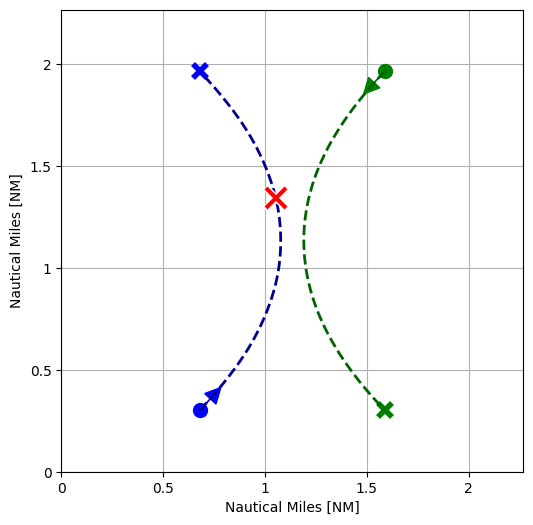

In [23]:
own_ship16 = [{'x': 90, 'y': 40, 'COG': 42.8, 'SOG': 12.5, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 108.9, 'y': 62, 'COG': 38.8, 'SOG': 12.5, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 123.8, 'y': 84, 'COG': 31.8, 'SOG': 12.5, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 134.2, 'y': 106, 'COG': 22.7, 'SOG': 12.5, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 140.5, 'y': 128, 'COG': 12.1, 'SOG': 12.5, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 142.5, 'y': 150, 'COG': 0, 'SOG': 12.5, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 140.5, 'y': 172, 'COG': 347.9, 'SOG': 12.5, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 134.2, 'y': 194, 'COG': 337.3, 'SOG': 12.5, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 123.8, 'y': 216, 'COG': 328.2, 'SOG': 12.5, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 108.9, 'y': 238, 'COG': 321.2, 'SOG': 12.5, 'heading': 321.3, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 90, 'y': 260, 'COG': 317.2, 'SOG': 12.5, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship16 = [{'x': 210.0, 'y': 260.0, 'COG': 222.8, 'SOG': 0, 'heading': 222.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 208.1, 'y': 258.0, 'COG': 222.6, 'SOG': 2.5, 'heading': 222.6, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 203.1, 'y': 252.4, 'COG': 221.5, 'SOG': 5, 'heading': 221.5, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 195.0, 'y': 242.9, 'COG': 219.3, 'SOG': 7.5, 'heading': 219.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 184.6, 'y': 229.1, 'COG': 215.0, 'SOG': 10, 'heading': 215.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 172.9, 'y': 209.9, 'COG': 207.3, 'SOG': 12.5, 'heading': 207.3, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 162.5, 'y': 184.4, 'COG': 196.8, 'SOG': 15, 'heading': 196.8, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 157.5, 'y': 152.4, 'COG': 181.1, 'SOG': 17.5, 'heading': 181.1, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 162.6, 'y': 115.3, 'COG': 163.2, 'SOG': 20, 'heading': 163.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 180.5, 'y': 76.9, 'COG': 147.4, 'SOG': 22.5, 'heading': 147.4, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 210.0, 'y': 40.0, 'COG': 137.2, 'SOG': 25, 'heading': 137.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa16 = [139.3, 177.7]
final_tcpa16 = 13.8
final_dcpa16 = 21.2

mse_ecpa16, mse_cpa16, mse_etcpa16, mse_tcpa16, mse_edcpa16, mse_dcpa16 = compute_mse(own_ship16, target_ship16, final_cpa16, 7, final_tcpa16, final_dcpa16)
overall_mse_ecpa.append(mse_ecpa16)
overall_mse_cpa.append(mse_cpa16)
overall_mse_etcpa.append(mse_etcpa16)
overall_mse_tcpa.append(mse_tcpa16)
overall_mse_edcpa.append(mse_edcpa16)
overall_mse_dcpa.append(mse_dcpa16)

print("MSE eCPA:", mse_ecpa16)
print("MSE CPA:", mse_cpa16)
print("MSE eTCPA:", mse_etcpa16)
print("MSE TCPA:", mse_tcpa16)
print("MSE eDCPA:", mse_edcpa16)
print("MSE DCPA:", mse_dcpa16)

plotting(own_ship16, target_ship16, final_cpa16)

#### Scenario 17

MSE eCPA: 23629.111872961388
MSE CPA: 42568.3523919176
MSE eTCPA: 163.1831719328904
MSE TCPA: 451.7835162802936
MSE eDCPA: 1532.939702643322
MSE DCPA: 981.306367677844


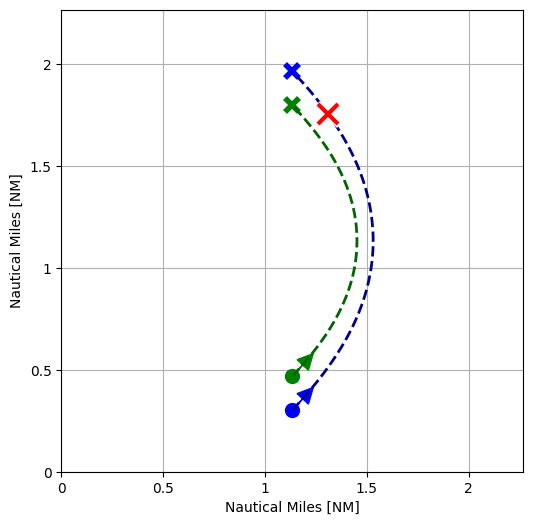

In [24]:
own_ship17 = [{'x': 150.0, 'y': 40.0, 'COG': 42.8, 'SOG': 0, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 151.9, 'y': 42.0, 'COG': 42.6, 'SOG': 2.5, 'heading': 42.6, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 156.9, 'y': 47.6, 'COG': 41.5, 'SOG': 5, 'heading': 41.5, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 165.0, 'y': 57.1, 'COG': 39.3, 'SOG': 7.5, 'heading': 39.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 175.4, 'y': 70.9, 'COG': 35.0, 'SOG': 10, 'heading': 35.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 187.1, 'y': 90.1, 'COG': 27.3, 'SOG': 12.5, 'heading': 27.3, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 197.5, 'y': 115.6, 'COG': 16.8, 'SOG': 15, 'heading': 16.8, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 202.5, 'y': 147.6, 'COG': 1.1, 'SOG': 17.5, 'heading': 1.1, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 197.4, 'y': 184.7, 'COG': 343.2, 'SOG': 20, 'heading': 343.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 179.5, 'y': 223.1, 'COG': 327.4, 'SOG': 22.5, 'heading': 327.4, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
              {'x': 150.0, 'y': 260.0, 'COG': 317.2, 'SOG': 25, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship17 = [{'x': 150, 'y': 62, 'COG': 42.8, 'SOG': 10.0, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 165.1, 'y': 79.6, 'COG': 38.8, 'SOG': 10.0, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 177, 'y': 97.2, 'COG': 31.8, 'SOG': 10.0, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 185.4, 'y': 114.8, 'COG': 22.7, 'SOG': 10.0, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 190.4, 'y': 132.4, 'COG': 12.1, 'SOG': 10.0, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 192, 'y': 150, 'COG': 0, 'SOG': 10.0, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 190.4, 'y': 167.6, 'COG': 347.9, 'SOG': 10.0, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 185.4, 'y': 185.2, 'COG': 337.3, 'SOG': 10.0, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 177, 'y': 202.8, 'COG': 328.2, 'SOG': 10.0, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 165.1, 'y': 220.4, 'COG': 321.2, 'SOG': 10.0, 'heading': 321.3, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
                {'x': 150, 'y': 238, 'COG': 317.2, 'SOG': 10.0, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa17 = [173.4, 232.1]
final_tcpa17 = 20.3
final_dcpa17 = 13.8

mse_ecpa17, mse_cpa17, mse_etcpa17, mse_tcpa17, mse_edcpa17, mse_dcpa17 = compute_mse(own_ship17, target_ship17, final_cpa17, 6, final_tcpa17, final_dcpa17)
overall_mse_ecpa.append(mse_ecpa17)
overall_mse_cpa.append(mse_cpa17)
overall_mse_etcpa.append(mse_etcpa17)
overall_mse_tcpa.append(mse_tcpa17)
overall_mse_edcpa.append(mse_edcpa17)
overall_mse_dcpa.append(mse_dcpa17)

print("MSE eCPA:", mse_ecpa17)
print("MSE CPA:", mse_cpa17)
print("MSE eTCPA:", mse_etcpa17)
print("MSE TCPA:", mse_tcpa17)
print("MSE eDCPA:", mse_edcpa17)
print("MSE DCPA:", mse_dcpa17)

plotting(own_ship17, target_ship17, final_cpa17)

#### Scenario 18

MSE eCPA: 1925.5313770020432
MSE CPA: 7525.930884871798
MSE eTCPA: 1.9786789976731056
MSE TCPA: 55.04528691011425
MSE eDCPA: 777.8241901749014
MSE DCPA: 7741.879886653898


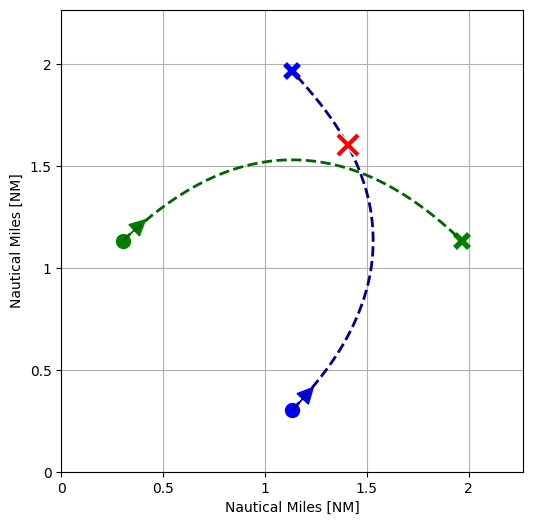

In [25]:
own_ship18 = [{'x': 150, 'y': 40, 'COG': 42.8, 'SOG': 12.5, 'heading': 42.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 62, 'COG': 38.8, 'SOG': 12.5, 'heading': 38.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 84, 'COG': 31.8, 'SOG': 12.5, 'heading': 31.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 106, 'COG': 22.7, 'SOG': 12.5, 'heading': 22.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 128, 'COG': 12.1, 'SOG': 12.5, 'heading': 12.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 202.5, 'y': 150, 'COG': 0, 'SOG': 12.5, 'heading': 0, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.5, 'y': 172, 'COG': 347.9, 'SOG': 12.5, 'heading': 347.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 194.2, 'y': 194, 'COG': 337.3, 'SOG': 12.5, 'heading': 337.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 183.8, 'y': 216, 'COG': 328.2, 'SOG': 12.5, 'heading': 328.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 168.9, 'y': 238, 'COG': 321.2, 'SOG': 12.5, 'heading': 321.2, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 317.2, 'SOG': 12.5, 'heading': 317.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship18 = [{'x': 40.0, 'y': 150.0, 'COG': 47.2, 'SOG': 0, 'heading': 47.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 42.0, 'y': 151.9, 'COG': 47.4, 'SOG': 2.5, 'heading': 47.4, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 47.6, 'y': 156.9, 'COG': 48.5, 'SOG': 5, 'heading': 48.5, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 57.1, 'y': 165.0, 'COG': 50.7, 'SOG': 7.5, 'heading': 50.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 70.9, 'y': 175.4, 'COG': 55.0, 'SOG': 10, 'heading': 55.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 90.1, 'y': 187.1, 'COG': 62.7, 'SOG': 12.5, 'heading': 62.7, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 115.6, 'y': 197.5, 'COG': 73.2, 'SOG': 15, 'heading': 73.2, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 147.6, 'y': 202.5, 'COG': 88.9, 'SOG': 17.5, 'heading': 88.9, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 184.7, 'y': 197.4, 'COG': 106.8, 'SOG': 20, 'heading': 106.8, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 223.1, 'y': 179.5, 'COG': 122.6, 'SOG': 22.5, 'heading': 122.6, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 260.0, 'y': 150.0, 'COG': 132.8, 'SOG': 25, 'heading': 132.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa18 = [186.1, 211.9]
final_tcpa18 = 17.2
final_dcpa18 = 15.2

mse_ecpa18, mse_cpa18, mse_etcpa18, mse_tcpa18, mse_edcpa18, mse_dcpa18 = compute_mse(own_ship18, target_ship18, final_cpa18, 8, final_tcpa18, final_dcpa18)
overall_mse_ecpa.append(mse_ecpa18)
overall_mse_cpa.append(mse_cpa18)
overall_mse_etcpa.append(mse_etcpa18)
overall_mse_tcpa.append(mse_tcpa18)
overall_mse_edcpa.append(mse_edcpa18)
overall_mse_dcpa.append(mse_dcpa18)

print("MSE eCPA:", mse_ecpa18)
print("MSE CPA:", mse_cpa18)
print("MSE eTCPA:", mse_etcpa18)
print("MSE TCPA:", mse_tcpa18)
print("MSE eDCPA:", mse_edcpa18)
print("MSE DCPA:", mse_dcpa18)

plotting(own_ship18, target_ship18, final_cpa18)

#### Scenario 19

MSE eCPA: 1484.3307398996155
MSE CPA: 5169.424580221287
MSE eTCPA: 0.8584335998148609
MSE TCPA: 30.76430045667583
MSE eDCPA: 136.74368397984182
MSE DCPA: 896.3044731378479


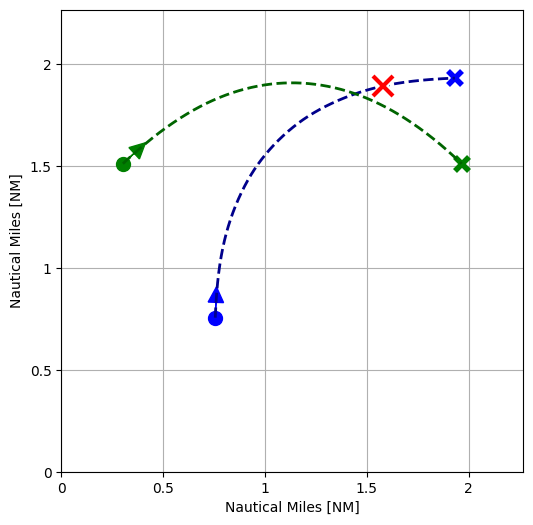

In [26]:
own_ship19 = [{'x': 100, 'y': 100, 'COG': 2.2, 'SOG': 12.5, 'heading': 2.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 102.2, 'y': 128.9, 'COG': 6.2, 'SOG': 12.5, 'heading': 6.2, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 107.2, 'y': 155, 'COG': 13.2, 'SOG': 12.5, 'heading': 13.2, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 115.4, 'y': 177.9, 'COG': 22.3, 'SOG': 12.5, 'heading': 22.3, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 126.5, 'y': 197.9, 'COG': 32.9, 'SOG': 12.5, 'heading': 32.9, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 140.7, 'y': 214.9, 'COG': 45, 'SOG': 12.5, 'heading': 45, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 157.6, 'y': 229, 'COG': 57.1, 'SOG': 12.5, 'heading': 57.1, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 177.6, 'y': 240.1, 'COG': 67.7, 'SOG': 12.5, 'heading': 67.7, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 200.6, 'y': 248.4, 'COG': 76.8, 'SOG': 12.5, 'heading': 76.8, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 226.6, 'y': 253.4, 'COG': 83.8, 'SOG': 12.5, 'heading': 83.8, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 255.6, 'y': 255.6, 'COG': 87.8, 'SOG': 12.5, 'heading': 87.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship19 = [{'x': 40.0, 'y': 200.0, 'COG': 47.2, 'SOG': 0, 'heading': 47.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 42.0, 'y': 201.9, 'COG': 47.4, 'SOG': 2.5, 'heading': 47.4, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 47.6, 'y': 206.9, 'COG': 48.5, 'SOG': 5, 'heading': 48.5, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 57.1, 'y': 215.0, 'COG': 50.7, 'SOG': 7.5, 'heading': 50.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 70.9, 'y': 225.4, 'COG': 55.0, 'SOG': 10, 'heading': 55.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 90.1, 'y': 237.1, 'COG': 62.7, 'SOG': 12.5, 'heading': 62.7, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 115.6, 'y': 247.5, 'COG': 73.2, 'SOG': 15, 'heading': 73.2, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 147.6, 'y': 252.5, 'COG': 88.9, 'SOG': 17.5, 'heading': 88.9, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 184.7, 'y': 247.4, 'COG': 106.8, 'SOG': 20, 'heading': 106.8, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 223.1, 'y': 229.5, 'COG': 122.6, 'SOG': 22.5, 'heading': 122.6, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 260.0, 'y': 200.0, 'COG': 132.8, 'SOG': 25, 'heading': 132.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa19 = [208.9, 250.4]
final_tcpa19 = 18.3
final_dcpa19 = 13.6

mse_ecpa19, mse_cpa19, mse_etcpa19, mse_tcpa19, mse_edcpa19, mse_dcpa19 = compute_mse(own_ship19, target_ship19, final_cpa19, 8, final_tcpa19, final_dcpa19)
overall_mse_ecpa.append(mse_ecpa19)
overall_mse_cpa.append(mse_cpa19)
overall_mse_etcpa.append(mse_etcpa19)
overall_mse_tcpa.append(mse_tcpa19)
overall_mse_edcpa.append(mse_edcpa19)
overall_mse_dcpa.append(mse_dcpa19)

print("MSE eCPA:", mse_ecpa19)
print("MSE CPA:", mse_cpa19)
print("MSE eTCPA:", mse_etcpa19)
print("MSE TCPA:", mse_tcpa19)
print("MSE eDCPA:", mse_edcpa19)
print("MSE DCPA:", mse_dcpa19)

plotting(own_ship19, target_ship19, final_cpa19)

#### Scenario 20

MSE eCPA: 11217.576976937275
MSE CPA: 57319.14393276444
MSE eTCPA: 85.1625952854191
MSE TCPA: 396.55899354537905
MSE eDCPA: 24459.399483852583
MSE DCPA: 20099.25231152879


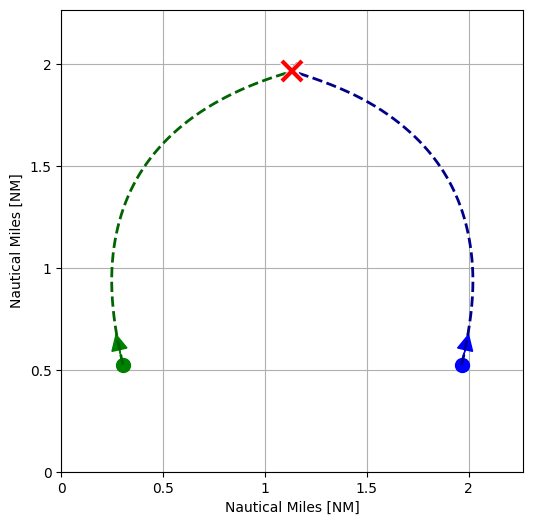

In [27]:
own_ship20 = [{'x': 260, 'y': 69.5, 'COG': 12.8, 'SOG': 12.5, 'heading': 12.8, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 265.4, 'y': 98, 'COG': 8.8, 'SOG': 12.5, 'heading': 8.8, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 267.3, 'y': 124.5, 'COG': 1.8, 'SOG': 12.5, 'heading': 1.8, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 265.3, 'y': 148.7, 'COG': 352.7, 'SOG': 12.5, 'heading': 352.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 259.7, 'y': 170.9, 'COG': 342.1, 'SOG': 12.5, 'heading': 342.1, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 250.5, 'y': 191, 'COG': 330, 'SOG': 12.5, 'heading': 330, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 237.7, 'y': 209, 'COG': 317.9, 'SOG': 12.5, 'heading': 317.9, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 221.3, 'y': 224.9, 'COG': 307.3, 'SOG': 12.5, 'heading': 307.3, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 201.3, 'y': 238.8, 'COG': 298.2, 'SOG': 12.5, 'heading': 298.2, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 177.4, 'y': 250.4, 'COG': 291.2, 'SOG': 12.5, 'heading': 291.2, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1},
             {'x': 150, 'y': 260, 'COG': 287.2, 'SOG': 12.5, 'heading': 287.2, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

target_ship20 = [{'x': 40.0, 'y': 69.5, 'COG': 347.2, 'SOG': 0, 'heading': 347.2, 'timestamp': 0.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 39.4, 'y': 72.2, 'COG': 347.3, 'SOG': 2.5, 'heading': 347.3, 'timestamp': 2.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 37.8, 'y': 79.5, 'COG': 348.4, 'SOG': 5, 'heading': 348.4, 'timestamp': 4.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 35.5, 'y': 91.8, 'COG': 350.7, 'SOG': 7.5, 'heading': 350.7, 'timestamp': 6.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 33.4, 'y': 108.9, 'COG': 355.0, 'SOG': 10, 'heading': 355.0, 'timestamp': 8.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 32.9, 'y': 131.4, 'COG': 2.7, 'SOG': 12.5, 'heading': 2.7, 'timestamp': 11.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 36.7, 'y': 158.7, 'COG': 13.5, 'SOG': 15, 'heading': 13.5, 'timestamp': 13.2, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 48.3, 'y': 188.9, 'COG': 28.8, 'SOG': 17.5, 'heading': 28.8, 'timestamp': 15.4, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 71.3, 'y': 218.4, 'COG': 46.6, 'SOG': 20, 'heading': 46.6, 'timestamp': 17.6, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 106.0, 'y': 242.8, 'COG': 62.6, 'SOG': 22.5, 'heading': 62.6, 'timestamp': 19.8, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}, 
                 {'x': 150.0, 'y': 260.0, 'COG': 72.8, 'SOG': 25, 'heading': 72.8, 'timestamp': 22.0, 'wind_factor': 0.3, 'current_factor': 0.1, 'bow': 3, 'stern': 2, 'portside': 1, 'starboard': 1}]

final_cpa20 = [150, 260]
final_tcpa20 = 22.0
final_dcpa20 = 0.0

mse_ecpa20, mse_cpa20, mse_etcpa20, mse_tcpa20, mse_edcpa20, mse_dcpa20 = compute_mse(own_ship20, target_ship20, final_cpa20, 10, final_tcpa20, final_dcpa20)
overall_mse_ecpa.append(mse_ecpa20)
overall_mse_cpa.append(mse_cpa20)
overall_mse_etcpa.append(mse_etcpa20)
overall_mse_tcpa.append(mse_tcpa20)
overall_mse_edcpa.append(mse_edcpa20)
overall_mse_dcpa.append(mse_dcpa20)

print("MSE eCPA:", mse_ecpa20)
print("MSE CPA:", mse_cpa20)
print("MSE eTCPA:", mse_etcpa20)
print("MSE TCPA:", mse_tcpa20)
print("MSE eDCPA:", mse_edcpa20)
print("MSE DCPA:", mse_dcpa20)

plotting(own_ship20, target_ship20, final_cpa20)

### Results of all Scenarios

In [28]:
print("Cumulative Overall MSE eCPA:", np.sum(overall_mse_ecpa))
print("Cumulative Overall MSE CPA:", np.sum(overall_mse_cpa))
print("Average Overall MSE eCPA:", np.mean(overall_mse_ecpa))
print("Average Overall MSE CPA:", np.mean(overall_mse_cpa), "\n")

print("Cumulative Overall MSE eTCPA:", np.sum(overall_mse_etcpa))
print("Cumulative Overall MSE TCPA:", np.sum(overall_mse_tcpa))
print("Average Overall MSE eTCPA:", np.mean(overall_mse_etcpa))
print("Average Overall MSE TCPA:", np.mean(overall_mse_tcpa), "\n")

print("Cumulative Overall MSE eDCPA:", np.sum(overall_mse_edcpa))
print("Cumulative Overall MSE DCPA:", np.sum(overall_mse_dcpa))
print("Average Overall MSE eDCPA:", np.mean(overall_mse_edcpa))
print("Average Overall MSE DCPA:", np.mean(overall_mse_dcpa), "\n")

# Check the length of the overall lists; must be the same as the number of scenarios
print("Length of eCPA List:", len(overall_mse_ecpa), " ---> ", len(overall_mse_ecpa) == 20)
print("Length of CPA List:", len(overall_mse_cpa), " ---> ", len(overall_mse_cpa) == 20)
print("Length of eTCPA List:", len(overall_mse_etcpa), " ---> ", len(overall_mse_etcpa) == 20)
print("Length of TCPA List:", len(overall_mse_tcpa), " ---> ", len(overall_mse_tcpa) == 20)
print("Length of eDCPA List:", len(overall_mse_edcpa), " ---> ", len(overall_mse_edcpa) == 20)
print("Length of DCPA List:", len(overall_mse_dcpa), " ---> ", len(overall_mse_dcpa) == 20)

Cumulative Overall MSE eCPA: 48532.776631552595
Cumulative Overall MSE CPA: nan
Average Overall MSE eCPA: 2426.63883157763
Average Overall MSE CPA: nan 

Cumulative Overall MSE eTCPA: 301.8112468557331
Cumulative Overall MSE TCPA: inf
Average Overall MSE eTCPA: 15.090562342786654
Average Overall MSE TCPA: inf 

Cumulative Overall MSE eDCPA: 44345.02290176401
Cumulative Overall MSE DCPA: nan
Average Overall MSE eDCPA: 2217.2511450882002
Average Overall MSE DCPA: nan 

Length of eCPA List: 20  --->  True
Length of CPA List: 20  --->  True
Length of eTCPA List: 20  --->  True
Length of TCPA List: 20  --->  True
Length of eDCPA List: 20  --->  True
Length of DCPA List: 20  --->  True


### Overall Plots

In [29]:
# Plot the given scenario.
def overview_plotting(own_ship, target_ship, final_cpa, axis_measure=[0, 300, 0, 300]):
    
    # Prepare the plot
    ax.axis(axis_measure)
    ax.axis('square')
    ax.set_xlim(axis_measure[0], axis_measure[1])
    ax.set_ylim(axis_measure[2], axis_measure[3])
    ax.grid(True)
    ax.set_xticks([0, 66.15, 132.3, 198.45, 264.6], ['0', '0.5', '1', '1.5', '2'])
    ax.set_yticks([0, 66.15, 132.3, 198.45, 264.6], ['0', '0.5', '1', '1.5', '2'])
    # ax.set_xlabel('Nautical Miles [NM]')
    # ax.set_ylabel('Nautical Miles [NM]')

    # Plot the ships starting positions
    ax.plot(own_ship[0]['x'], own_ship[0]['y'], "ob", markersize=10, zorder=2)
    ax.plot(target_ship[0]['x'], target_ship[0]['y'], "og", markersize=10, zorder=2)

    # Plot the ships heading as arrow with constant length
    ax.arrow(own_ship[0]['x'], own_ship[0]['y'], 10 * math.sin(math.radians(own_ship[0]['heading'])),
                10 * math.cos(math.radians(own_ship[0]['heading'])),
                head_width=10, head_length=10, color='b', zorder=2)
    ax.arrow(target_ship[0]['x'], target_ship[0]['y'], 10 * math.sin(math.radians(target_ship[0]['heading'])),
                10 * math.cos(math.radians(target_ship[0]['heading'])),
                head_width=10, head_length=10, color='g', zorder=2)
    
    # Plot the ships final positions
    ax.plot(own_ship[-1]['x'], own_ship[-1]['y'], "xb", markersize=10, markeredgewidth=4, zorder=2)
    ax.plot(target_ship[-1]['x'], target_ship[-1]['y'], "xg", markersize=10, markeredgewidth=4, zorder=2)
        
    # Extract the position coordinates from the data
    x1_positions = [entry['x'] for entry in own_ship]
    y1_positions = [entry['y'] for entry in own_ship]
    x2_positions = [entry['x'] for entry in target_ship]
    y2_positions = [entry['y'] for entry in target_ship]

    # Interpolate the paths by the chosen method (linear, quadratic, cubic, cubic_spline, cubic_hermite_spline, pchip, akima)
    interpolated_x1, interpolated_y1 = interpolate_path(x1_positions, y1_positions, 'cubic_spline')
    interpolated_x2, interpolated_y2 = interpolate_path(x2_positions, y2_positions, 'cubic_spline')
    
    # Plot the interpolated course of the ships
    ax.plot(interpolated_x1, interpolated_y1, color='darkblue', linestyle='--', linewidth=2)
    ax.plot(interpolated_x2, interpolated_y2, color='darkgreen', linestyle='--', linewidth=2)

    # Plot the CPA as red 'X'
    ax.plot(final_cpa[0], final_cpa[1], "x", markersize=16.5, markeredgewidth=5, color='white')
    ax.plot(final_cpa[0], final_cpa[1], "xr", markersize=15, markeredgewidth=3)

In [32]:
import matplotlib.gridspec as gridspec
import scienceplots  # https://github.com/garrettj403/SciencePlots?tab=readme-ov-file
plt.style.use(['science', 'notebook', 'ieee'])  # , 'ieee','grid'

# Format the scenario data
scenarios = [[own_ship11, target_ship11, final_cpa11],
             [own_ship12, target_ship12, final_cpa12],
             [own_ship13, target_ship13, final_cpa13],
             [own_ship14, target_ship14, final_cpa14],
             [own_ship15, target_ship15, final_cpa15],
             [own_ship16, target_ship16, final_cpa16],
             [own_ship17, target_ship17, final_cpa17],
             [own_ship18, target_ship18, final_cpa18],
             [own_ship19, target_ship19, final_cpa19],
             [own_ship20, target_ship20, final_cpa20]]

# Create figure with a 4x3 grid of subplots
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(3, 4, figure=fig)

# Plot scenarios 1 to 10 in the first 10 tiles
for i in range(10):
    ax = fig.add_subplot(gs[i // 4, i % 4])
    # ax.set_title(f'Scenario {i + 1}', loc='left')
    ax.text(0.02, 0.98, f'Scenario {i + 11}', transform=ax.transAxes, verticalalignment='top', fontsize=15)
    # Plot each scenario
    overview_plotting(scenarios[i][0], scenarios[i][1], scenarios[i][2])
    # Only set y-axis label for leftmost subplots
    if i % 4 == 0:  # Adjust based on your grid layout
        ax.set_ylabel('Nautical Miles [NM]', fontsize=15)
    else:
        ax.set_yticklabels([])  # This hides the y-axis labels
    # Hide x-axis labels for all but the last row
    if i < 8:  # Adjust based on your grid layout
        ax.set_xticklabels([])  # This hides the x-axis labels
    else:
        ax.set_xlabel('Nautical Miles [NM]', fontsize=15)
    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=15)

# Merge the last two tiles for the Variations in SOG plot
ax_big = fig.add_subplot(gs[2, 2:])
# Plotting SOG 
# ax_big.plot(x_smooth10, y_smooth10, color='green', label='SOG with Varying Acceleration')
ax_big.plot(np.arange(11), [10] * 11, color='blue', label='SOG with Constant Speed')
# ax_big.plot(np.arange(11), sog_10, 'o', color='blue', label='SOG Timestamps')
ax_big.plot(np.arange(11), sog_10_const, color='green', label='SOG with Constant Acceleration')
# ax_big.plot(np.arange(11), sog_10_const, 'o', color='green', label='SOG Timestamps')
ax_big.text(0.02, 0.98, 'Variations in SOG with Base Speed 10 Knots', transform=ax_big.transAxes, verticalalignment='top', fontsize=15)
ax_big.set_xlabel('Timesteps', fontsize=15)
# ax_big.set_ylabel('SOG')
ax_big.grid()
ax_big.legend(loc='lower right', fontsize=15)
ax_big.tick_params(axis='both', which='major', labelsize=15)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.tight_layout(pad=3, w_pad=0.5, h_pad=1.0)
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


In [31]:
import matplotlib.gridspec as gridspec
import scienceplots  # https://github.com/garrettj403/SciencePlots?tab=readme-ov-file
plt.style.use(['science', 'notebook', 'ieee'])  # , 'ieee','grid'

# Format the scenario data
scenarios = [[own_ship1, target_ship1, final_cpa1],
             [own_ship2, target_ship2, final_cpa2],
             [own_ship3, target_ship3, final_cpa3],
             [own_ship4, target_ship4, final_cpa4],
             [own_ship5, target_ship5, final_cpa5],
             [own_ship6, target_ship6, final_cpa6],
             [own_ship7, target_ship7, final_cpa7],
             [own_ship8, target_ship8, final_cpa8],
             [own_ship9, target_ship9, final_cpa9],
             [own_ship10, target_ship10, final_cpa10]]

# Create figure with a 4x3 grid of subplots
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(3, 4, figure=fig)

# Plot scenarios 1 to 10 in the first 10 tiles
for i in range(10):
    ax = fig.add_subplot(gs[i // 4, i % 4])
    # ax.set_title(f'Scenario {i + 1}', loc='left')
    ax.text(0.02, 0.98, f'Scenario {i + 1}', transform=ax.transAxes, verticalalignment='top', fontsize=15)
    # Plot each scenario
    overview_plotting(scenarios[i][0], scenarios[i][1], scenarios[i][2])
    # Only set y-axis label for leftmost subplots
    if i % 4 == 0:  # Adjust based on your grid layout
        ax.set_ylabel('Nautical Miles [NM]', fontsize=15)
    else:
        ax.set_yticklabels([])  # This hides the y-axis labels
    # Hide x-axis labels for all but the last row
    if i < 8:  # Adjust based on your grid layout
        ax.set_xticklabels([])  # This hides the x-axis labels
    else:
        ax.set_xlabel('Nautical Miles [NM]', fontsize=15)
    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=15)

# Merge the last two tiles for the Variations in SOG plot
ax_big = fig.add_subplot(gs[2, 2:])
# Plotting SOG 
# ax_big.plot(x_smooth10, y_smooth10, color='green', label='SOG with Varying Acceleration')
ax_big.plot(np.arange(11), [10] * 11, color='blue', label='SOG with Constant Speed')
# ax_big.plot(np.arange(11), sog_10, 'o', color='blue', label='SOG Timestamps')
ax_big.plot(np.arange(11), sog_10_const, color='green', label='SOG with Constant Acceleration')
# ax_big.plot(np.arange(11), sog_10_const, 'o', color='green', label='SOG Timestamps')
ax_big.text(0.02, 0.98, 'Variations in SOG with Base Speed 10 Knots', transform=ax_big.transAxes, verticalalignment='top', fontsize=15)
ax_big.set_xlabel('Timesteps', fontsize=15)
# ax_big.set_ylabel('SOG')
ax_big.grid()
ax_big.legend(loc='lower right', fontsize=15)
ax_big.tick_params(axis='both', which='major', labelsize=15)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.tight_layout(pad=3, w_pad=0.5, h_pad=1.0)
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
